# BÉT

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
bux = pd.read_csv(
    "../data/limited/bux.csv",
    parse_dates=True,
    index_col="Dátum"
)
bux.index.freq = "B"

## Plot

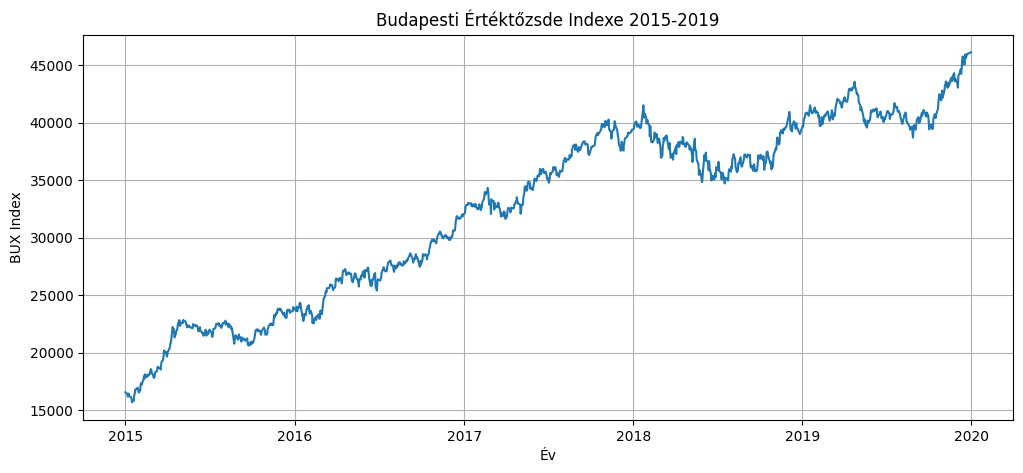

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(bux)
plt.title("Budapesti Értéktőzsde Indexe 2015-2019")
plt.xlabel("Év")
plt.ylabel("BUX Index")
plt.grid(True)
plt.savefig("../docs/figures/bux.png")
plt.savefig("../docs/figures/bux.svg")
plt.show()

## Split dataset

In [4]:
bux_train = bux.loc[:"2018"]
bux_test = bux.loc["2019":]
bux_train.index.freq = "B"
bux_test.index.freq = "B"

## SARIMA

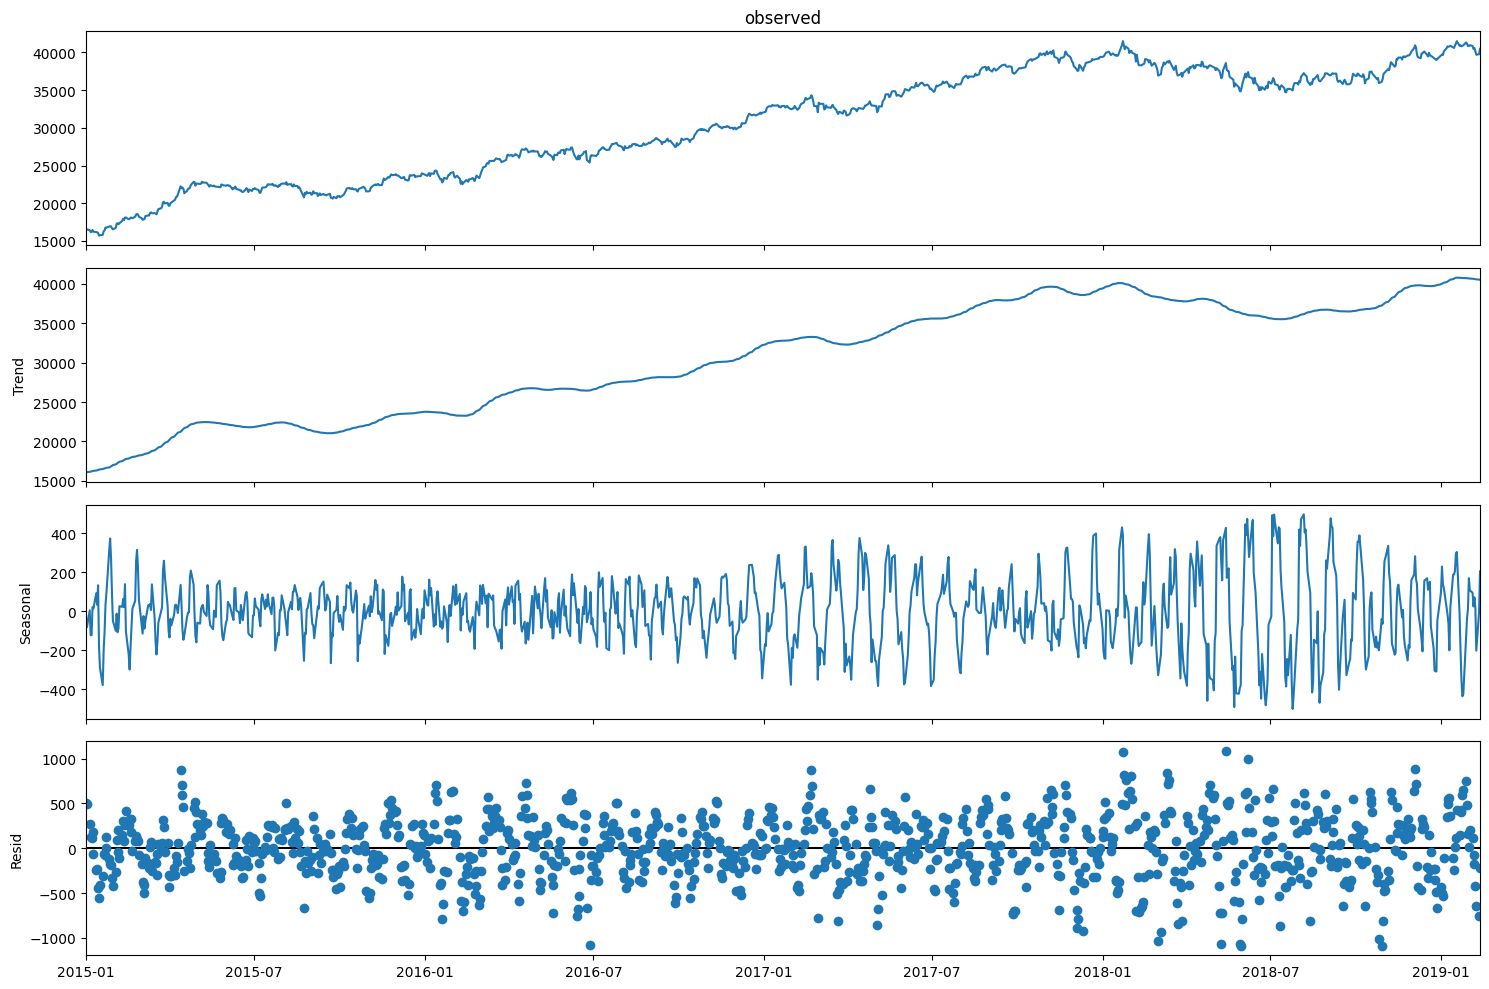

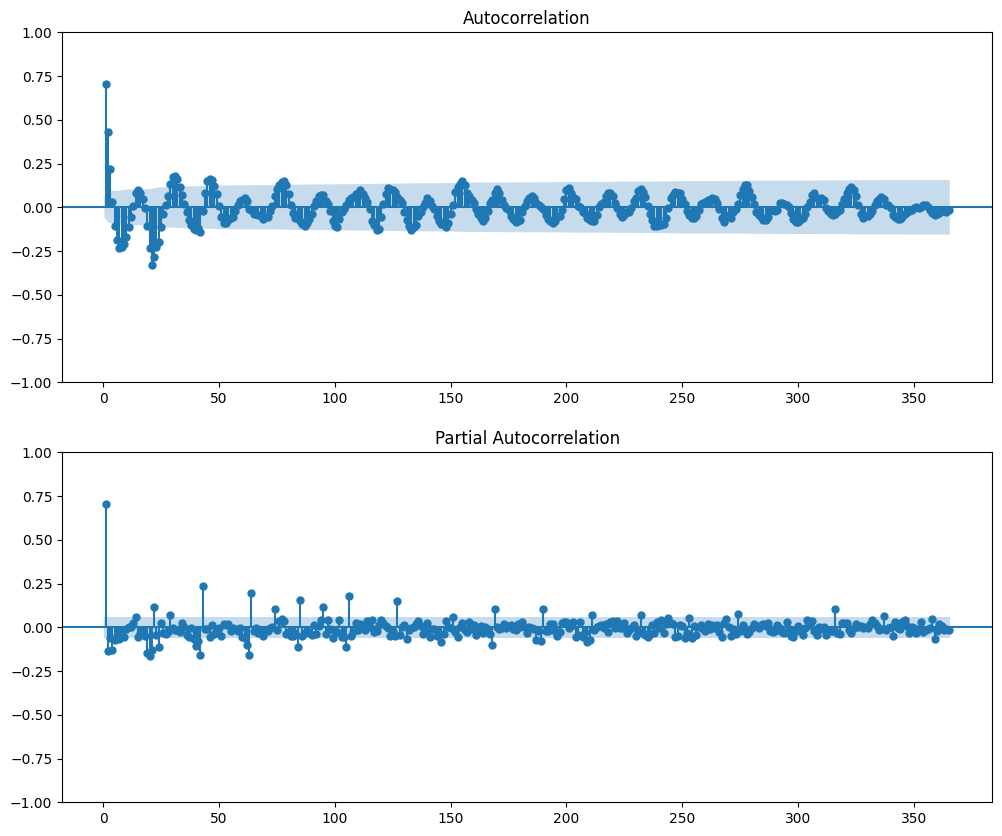

/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


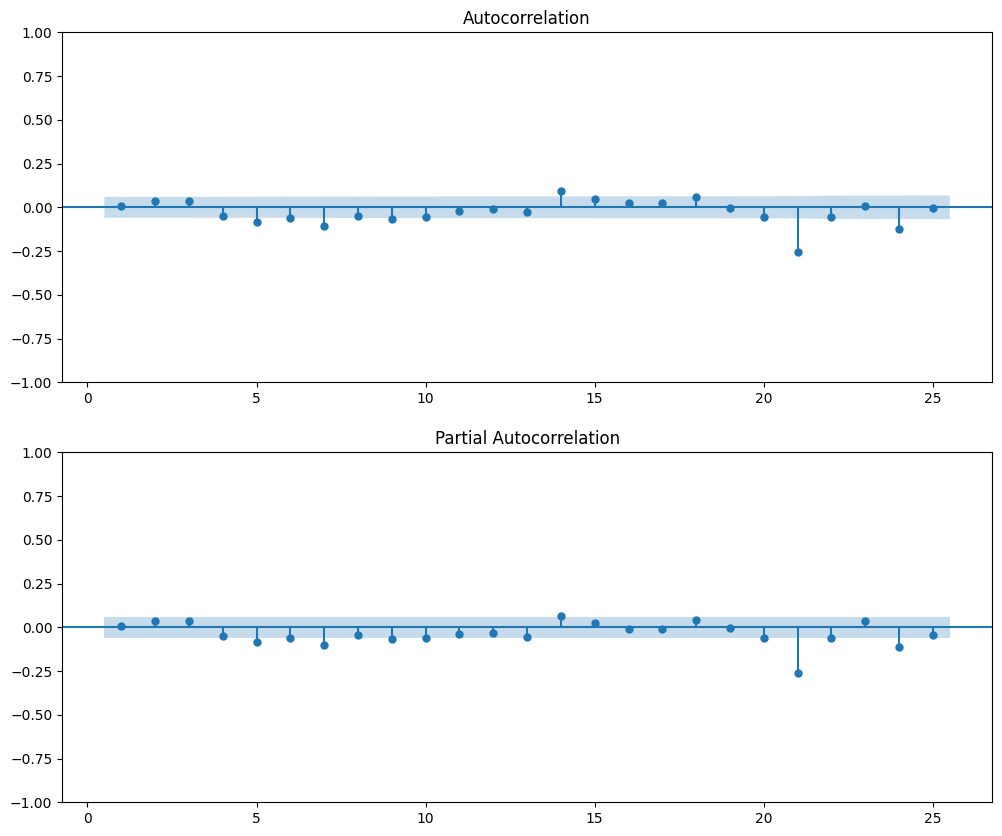

/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.1/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/titinho/.pyenv/versions/3.13.

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import MSTL

# 1. Step: Create MSTL model with weekly and yearly periodicity
mstl = MSTL(bux_train["Utolsó ár"], periods=(21))
mstl_result = mstl.fit()
fig = mstl_result.plot()
fig.set_size_inches(15, 10)
plt.tight_layout()
plt.show()


# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
plot_acf(mstl_result.resid, lags=365, zero=False, ax=ax1)
plot_pacf(mstl_result.resid, lags=365, zero=False, ax=ax2)
plt.show()

# 2. Step: plot residuals ARIMA
resid_arima = ARIMA(mstl_result.resid, order=(1, 0, 1)).fit()
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,10))
plot_acf(resid_arima.resid, lags=25, zero=False, ax=ax1)
plot_pacf(resid_arima.resid, lags=25, zero=False, ax=ax2)
plt.show()


# Forecasting
bux_forecast = pd.DataFrame(
    index=bux_test.index,
    columns=bux_test.columns
)
for i, date in enumerate(bux_test.index):
    # Create MSTL model with weekly and yearly periodicity
    mstl = MSTL(bux_train["Utolsó ár"], periods=(21))
    mstl_result = mstl.fit()

    # Decomposition
    trend = mstl_result.trend
    seasonal_021 = mstl_result.seasonal
    resid = mstl_result.resid

    resid_arima = ARIMA(resid, order=(1, 0, 1)).fit()

    # Forecasting
    trend_forecast = trend.iloc[-1]
    seasonal_021_forecast = seasonal_021.iloc[-(21 - (i % 21))] if i % 21 != 0 else seasonal_021.iloc[-21]

    seasonal_forecast = seasonal_021_forecast
    resid_forecast = resid_arima.forecast(steps=1).iloc[0]

    forecast = trend_forecast + seasonal_forecast + resid_forecast

    bux_forecast.loc[date, "Utolsó ár"] = forecast

    actual_value = bux_test.loc[date, "Utolsó ár"]

    new_row = pd.DataFrame(
        {"Utolsó ár": [actual_value]}, 
        index=[date]
    )
    new_row.index.freq = "D"
    bux_train = pd.concat([bux_train, new_row])

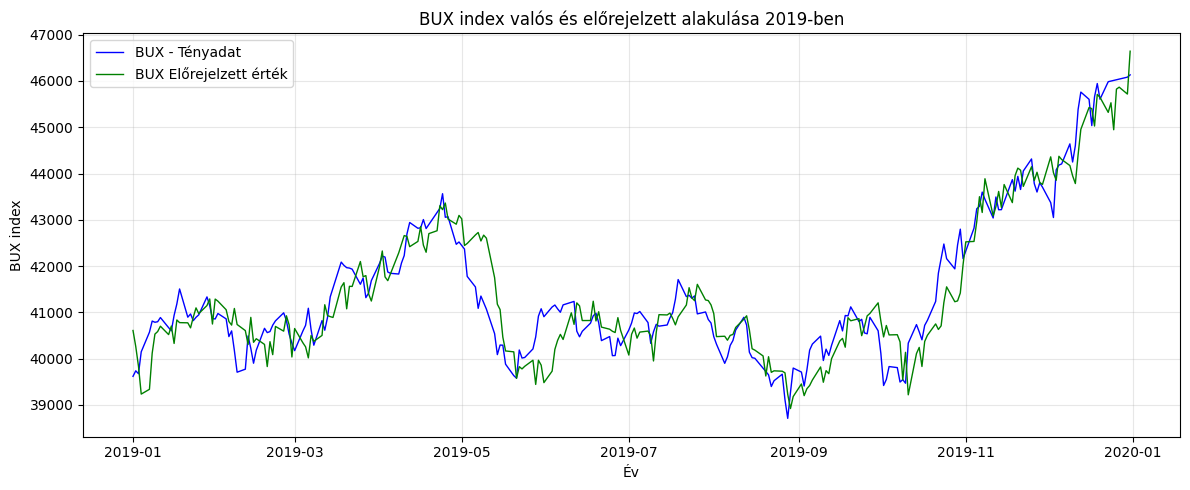

In [ ]:
# Plot the result
plt.figure(figsize=(12, 5))

# Plot actual data (differences)
plt.plot(
    bux_test.index,
    bux_test["Utolsó ár"], 
    label="BUX - Tényadat",
    color="blue",
    linewidth=1,
)

# Plot forecasted data
plt.plot(
    bux_forecast.index,
    bux_forecast["Utolsó ár"],
    label="BUX - Előrejelzett érték",
    color="green",
    linewidth=1,
)

plt.title("BUX index valós és előrejelzett alakulása 2019-ben")
plt.xlabel("Év")
plt.ylabel("BUX index")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../docs/figures/bux_daily_forecast.png")
plt.savefig("../docs/figures/bux_daily_forecast.svg")
plt.show()